# Car prices dataset assignment

## 1. Exploratory Data Analysis

### 1.1 Import packages

In [1]:
import numpy as np
import pandas as pd
from plotnine import * 
import os
import scipy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import HTML 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


### 1.2 Read data from path

An extra column is loaded due to having data but no column name. 
This is because of an error of data in the dataset and will be adjusted after.

In [2]:
# Get the current working directory
cwd = os.getcwd()

# List all the directories and files in the parent directory of 'dataset'
dir_list = os.listdir(os.path.join(cwd, 'dataset'))

car_prices_data_path = os.path.join( "dataset", "car_prices.csv")

# Read csv file and name column to make sure the 17th column is included
df = pd.read_csv(car_prices_data_path, header=None, names=[f'col{i}' for i in range(1, 18)])

# Give the first row of this column a value
df.iloc[0, 16] = 'extra'

# Now, use the first row as column names
df.columns = df.iloc[0]

# Drop the first row since it's now redundant as column names
df = df[1:]

C:\Users\daanv\AppData\Local\Temp\ipykernel_8544\1971989314.py:10: DtypeWarning: Columns (0,8,9,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.


### 1.3 Clean the data

The unalligned data is alligned into the correct columns

In [3]:
# Filter rows with data in the 'extra' column
df_extra = df[df['extra'].notnull()]

# Include columns starting from column 5 onwards
df_extra = df_extra.iloc[:, 5:]

# Replace column names with the name of the column to the right
df_extra.columns = df_extra.columns.to_series().shift(+1).fillna('body')

# Iterate over the rows of df_extra and update values in df
for index, row in df_extra.iterrows():
    for column_name in df.columns:
        # Update values in df only for shared rows and columns
        if column_name in df_extra.columns and index in df.index:
            df.at[index, column_name] = row[column_name]

# drop the 'extra' column from the dataframe
df = df.drop('extra', axis=1)

Change data types

In [4]:
# Convert columns to appropriate data types
df['year'] = df['year'].astype('int')
df['odometer'] = df['odometer'].astype('float')
df['mmr'] = df['mmr'].astype('float')
df['sellingprice'] = df['sellingprice'].astype('float')
df['condition'] = df['condition'].astype('float')
df['saledate'] = pd.to_datetime(df['saledate'])

Numeric statistics

In [5]:
# Calculate shape
print("There are {} rows and {} columns in the dataset".format(df.shape[0], df.shape[1]))

# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number'])

# get statistics for numeric columns
nan_counts_numeric = numeric_columns.isnull().sum()
unique_counts_numeric = numeric_columns.nunique()
mode_counts_numeric = numeric_columns.mode().iloc[0]
max_values_numeric = numeric_columns.max()
min_values_numeric = numeric_columns.min()
percentage_nan_numeric = numeric_columns.isnull().mean() * 100
mean_values_numeric = numeric_columns.mean()
median_values_numeric = numeric_columns.median()
variance_values_numeric = numeric_columns.var()
std_dev_values_numeric = numeric_columns.std()
skewness_values_numeric = numeric_columns.skew()
kurtosis_values_numeric = numeric_columns.kurt()

# create a new dataframe with the statistics for numeric columns
numeric_statistics = pd.DataFrame({'Nan Count': nan_counts_numeric,
                                    'Unique Count': unique_counts_numeric,
                                    'Mode Count': mode_counts_numeric,
                                    'Max Value': max_values_numeric,
                                    'Min Value': min_values_numeric,
                                    'Percentage Nan': percentage_nan_numeric,
                                    'Mean Value': mean_values_numeric,
                                    'Median Value': median_values_numeric,
                                    'Variance Value': variance_values_numeric,
                                    'Standard Deviation Value': std_dev_values_numeric,
                                    'Skewness Value': skewness_values_numeric,
                                    'Kurtosis Value': kurtosis_values_numeric})

# print the numeric statistics dataframe
print(numeric_statistics)


There are 558837 rows and 16 columns in the dataset
              Nan Count  Unique Count  Mode Count  Max Value  Min Value  \
0                                                                         
year                  0            34      2012.0     2015.0     1982.0   
condition         11794            41         1.9        5.0        1.0   
odometer             94        172280         1.0   999999.0        1.0   
mmr                   0          1101     12500.0   182000.0       25.0   
sellingprice          0          1887     11000.0   230000.0        1.0   

              Percentage Nan    Mean Value  Median Value  Variance Value  \
0                                                                          
year                0.000000   2010.038927        2012.0    1.573601e+01   
condition           2.110454      3.424511           3.6    9.014787e-01   
odometer            0.016821  68320.437548       52254.0    2.851353e+09   
mmr                 0.000000  13769.319811

Non numeric statistics

In [6]:
# Select only non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number'])

# get statistics for non-numeric columns
unique_counts_non_numeric = non_numeric_columns.nunique()
mode_counts_non_numeric = non_numeric_columns.mode().iloc[0]
nan_counts_non_numeric = non_numeric_columns.isnull().sum()
percentage_nan_non_numeric = non_numeric_columns.isnull().mean() * 100

# create a new dataframe with the statistics for non-numeric columns
non_numeric_statistics = pd.DataFrame({'Nan Count': nan_counts_non_numeric,
                                       'Unique Count': unique_counts_non_numeric,
                                       'Mode Count': mode_counts_non_numeric,
                                       'Percentage Nan': percentage_nan_non_numeric})

# print the non-numeric statistics dataframe
print(non_numeric_statistics)


              Nan Count  Unique Count                 Mode Count  \
0                                                                  
make              10301            96                       Ford   
model             10399           973                     Altima   
trim              10651          1976                       Base   
body              13195            86                      Sedan   
transmission      65357             2                  automatic   
vin                   0        550322          wbanv13588cz57827   
state                 0            38                         fl   
color               749            20                      black   
interior            749            17                      black   
seller                0         14264         nissan-infiniti lt   
saledate              0          3745  2015-02-10 01:30:00+08:00   

              Percentage Nan  
0                             
make                1.843292  
model               1.

Filling missing values

In [7]:
grouped = df.groupby('model')
modes = grouped['transmission'].apply(lambda x: stats.mode(x)[0][0])
df['transmission'].fillna(df['model'].map(modes), inplace=True)

# Calculate the mode of the 'transmission' column
mode = df['transmission'].mode()[0]

# Fill the remaining NaN values in the 'transmission' column with the calculated mode
df['transmission'].fillna(mode, inplace=True)

# Calculate the mode of the 'transmission' column
mode = df['transmission'].mode()[0]

# Drop all rows with NaN values in the other rows
df.dropna(inplace=True)

C:\Users\daanv\AppData\Local\Temp\ipykernel_8544\2772787595.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
c:\Users\daanv\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
C:\Users\daanv\AppData\Local\Temp\ipykernel_8544\2772787595.py:2: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.


Check if NaN values are filtered out and shape of remaining dataframe

In [8]:
# Select only non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number'])

# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number'])

# get statistics for numeric columns
nan_counts_numeric = numeric_columns.isnull().sum()
unique_counts_numeric = numeric_columns.nunique()
percentage_nan_numeric = numeric_columns.isnull().mean() * 100


# create a new dataframe with the statistics for numeric columns
numeric_statistics = pd.DataFrame({'Nan Count': nan_counts_numeric,
                                    'Unique Count': unique_counts_numeric,
                                    'Percentage Nan': percentage_nan_numeric})


# print the numeric statistics dataframe
print(numeric_statistics)

# get statistics for non-numeric columns
unique_counts_non_numeric = non_numeric_columns.nunique()
nan_counts_non_numeric = non_numeric_columns.isnull().sum()
percentage_nan_non_numeric = non_numeric_columns.isnull().mean() * 100

# create a new dataframe with the statistics for non-numeric columns
non_numeric_statistics = pd.DataFrame({'Nan Count': nan_counts_non_numeric,
                                       'Unique Count': unique_counts_non_numeric,
                                       'Percentage Nan': percentage_nan_non_numeric})

# print the non-numeric statistics dataframe
print(non_numeric_statistics)

# Calculate shape
print("There are {} rows and {} columns in the dataset".format(df.shape[0], df.shape[1]))

              Nan Count  Unique Count  Percentage Nan
0                                                    
year                  0            26             0.0
condition             0            41             0.0
odometer              0        166560             0.0
mmr                   0          1101             0.0
sellingprice          0          1852             0.0
              Nan Count  Unique Count  Percentage Nan
0                                                    
make                  0            53             0.0
model                 0           772             0.0
trim                  0          1524             0.0
body                  0            86             0.0
transmission          0             2             0.0
vin                   0        525676             0.0
state                 0            38             0.0
color                 0            20             0.0
interior              0            17             0.0
seller                0     

### 1.4 Correlation and descriptive analysis

Create a correlation heatmap

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

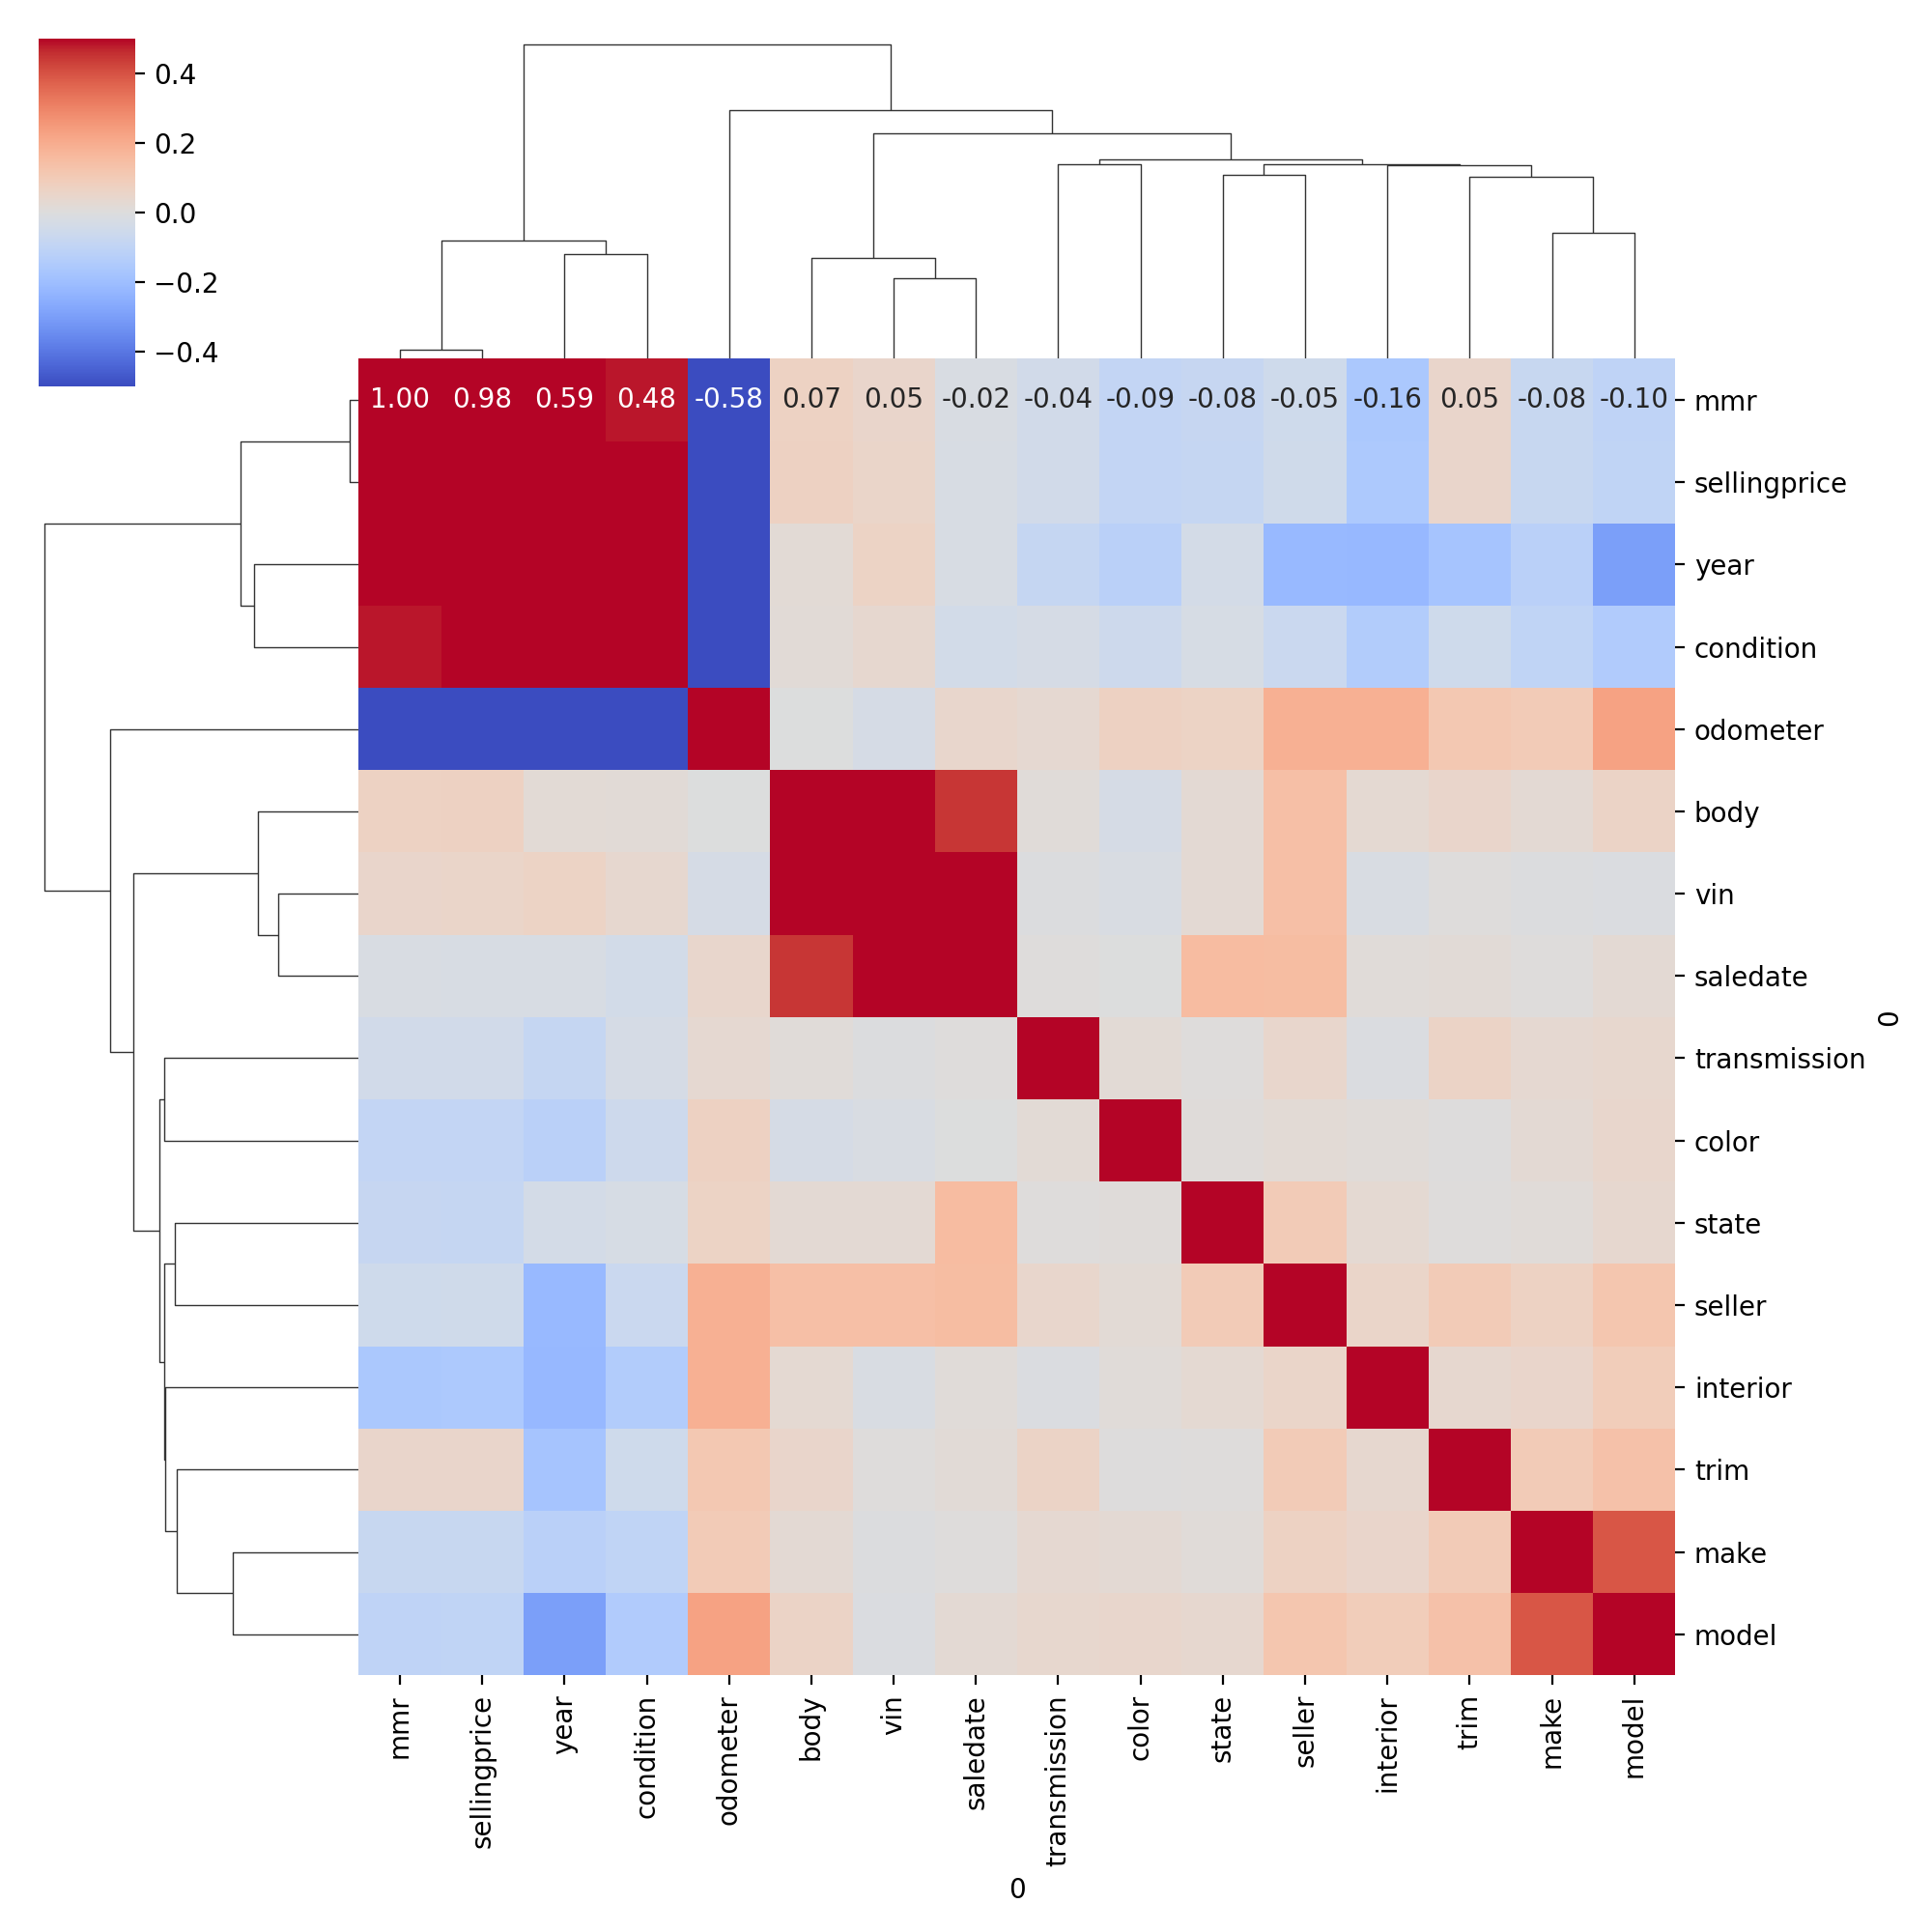

In [24]:
# Factorize categorical columns
for column in df.select_dtypes(exclude=[np.number]).columns:
    df[column], _ = pd.factorize(df[column])

# Compute the correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-0.5, vmax=0.5)

# Show the plot
plt.show()

Look into the transmission column to check for imbalance

In [10]:
result = (
    df.groupby('transmission')
    .size()
    .reset_index(name='N')
    .assign(total = lambda x: x.N.sum())
    .assign(p = lambda x: x.N / x.total * 100)
)
print(result)

filtered_result = result[result['p'] < 5]
if not filtered_result.empty:
    print('The data is imbalanced')
else:
    print('The data is balanced')

  transmission       N   total          p
0    automatic  517259  533686  96.921973
1       manual   16427  533686   3.078027
The data is imbalanced


Look into the interior column to check for imbalance

In [11]:
result = (
    df.groupby('interior')
    .size()
    .reset_index(name='N')
    .assign(total = lambda x: x.N.sum())
    .assign(p = lambda x: x.N / x.total * 100)
)
print(result)

filtered_result = result[result['p'] < 5]
if not filtered_result.empty:
    print('The data is imbalanced')
else:
    print('The data is balanced')

     interior       N   total          p
0       beige   57868  533686  10.843080
1       black  238690  533686  44.724801
2        blue    1013  533686   0.189812
3       brown    8296  533686   1.554472
4    burgundy     184  533686   0.034477
5        gold     313  533686   0.058649
6        gray  170432  533686  31.934883
7       green     223  533686   0.041785
8   off-white     469  533686   0.087879
9      orange     134  533686   0.025108
10     purple     326  533686   0.061085
11        red    1298  533686   0.243214
12     silver    1053  533686   0.197307
13        tan   41703  533686   7.814145
14      white     239  533686   0.044783
15     yellow      19  533686   0.003560
16          —   11426  533686   2.140959
The data is imbalanced


### 1.5 Distribution visualization

In [13]:
def generate_freq_table(df, variable = ['transmission']):
    dfs = []
    for i in variable:
        df_count = (
            df.groupby(i, observed=False)
            .size()
            .reset_index(name='N')
            .assign(var = i)
            .rename(columns={i: 'category'})
        )
        dfs.append(df_count)
        res = pd.concat(dfs)
        res['category'] = res['category'].astype(str)
    return res

In [14]:
generate_freq_table(df, ['transmission', 'interior', 'color', 'state'])

,category,N,var
0,automatic,517259,transmission
1,manual,16427,transmission
0,beige,57868,interior
1,black,238690,interior
2,blue,1013,interior
...,...,...,...
33,tx,43704,state
34,ut,1726,state
35,va,11248,state
36,wa,7117,state


In [15]:
def generate_freq_plot(freq_table):
    return (
        ggplot(freq_table, aes(x='var', y='N', fill='category')) +
        geom_col(stat='identity', position='dodge')
    )

In [16]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object', name=0)

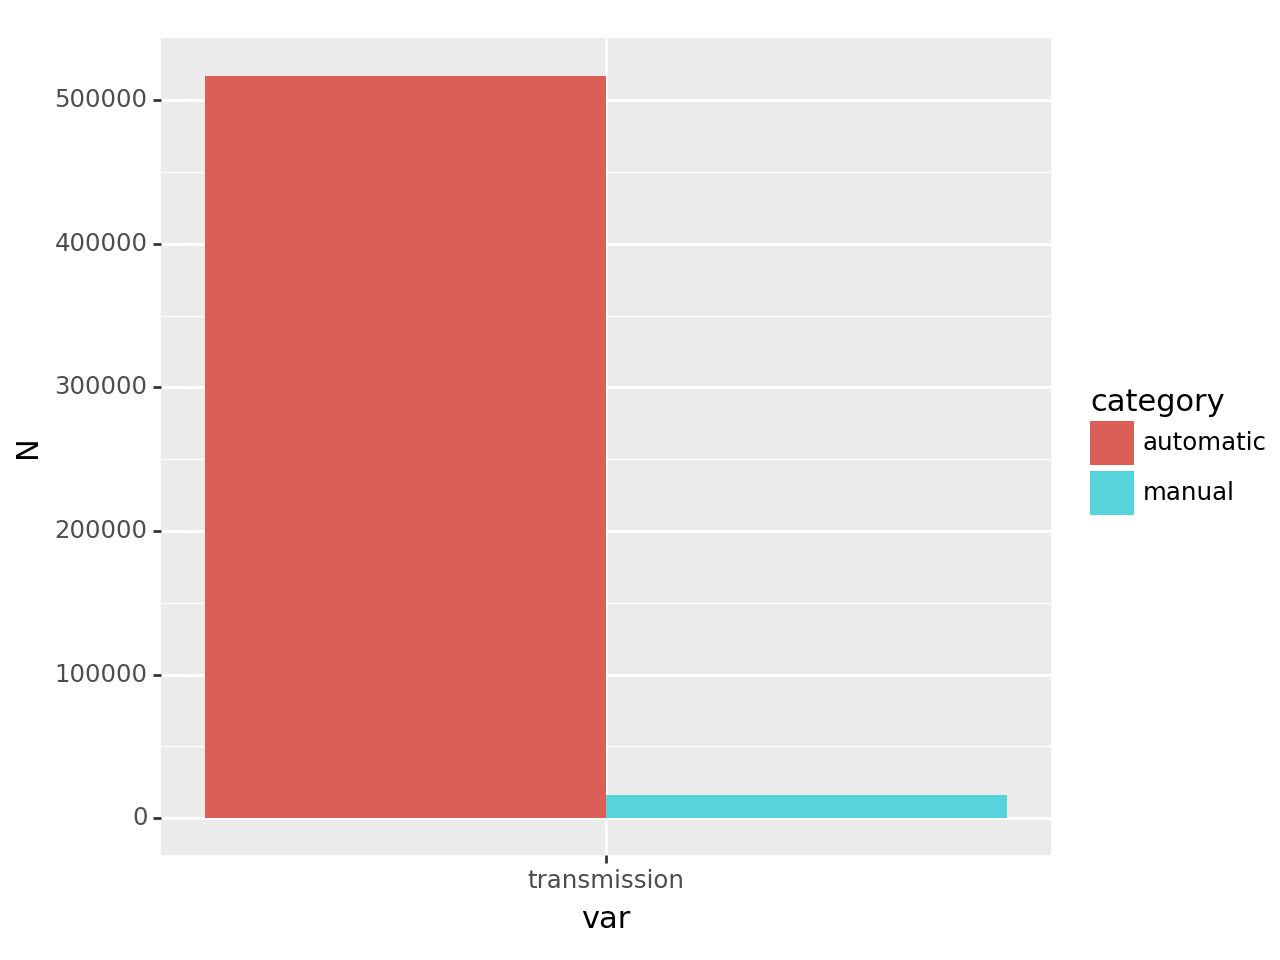

<Figure Size: (640 x 480)>

In [17]:
generate_freq_plot(generate_freq_table(df, ['transmission']))

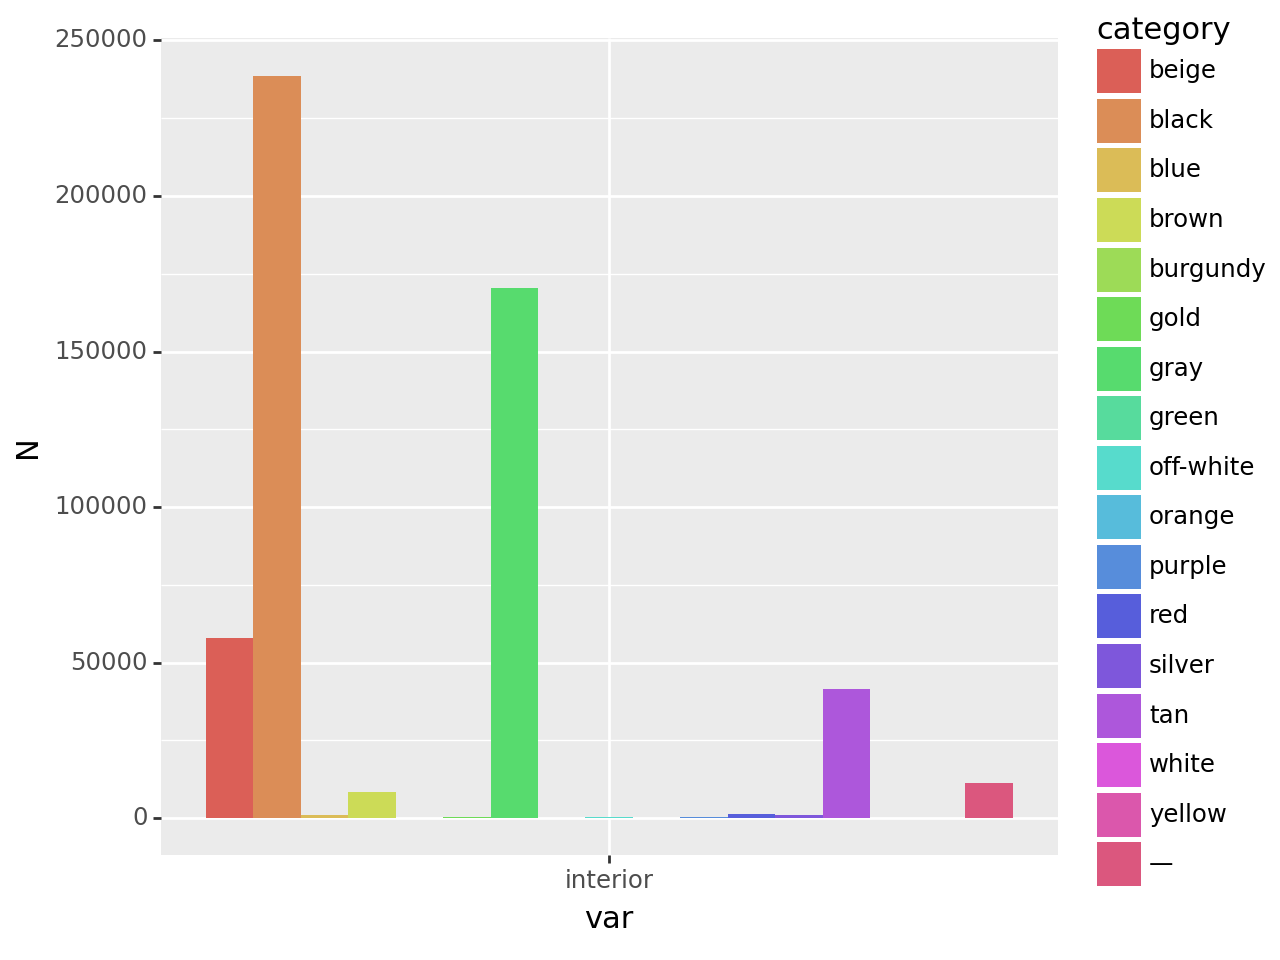

<Figure Size: (640 x 480)>

In [18]:
generate_freq_plot(generate_freq_table(df, ['interior']))

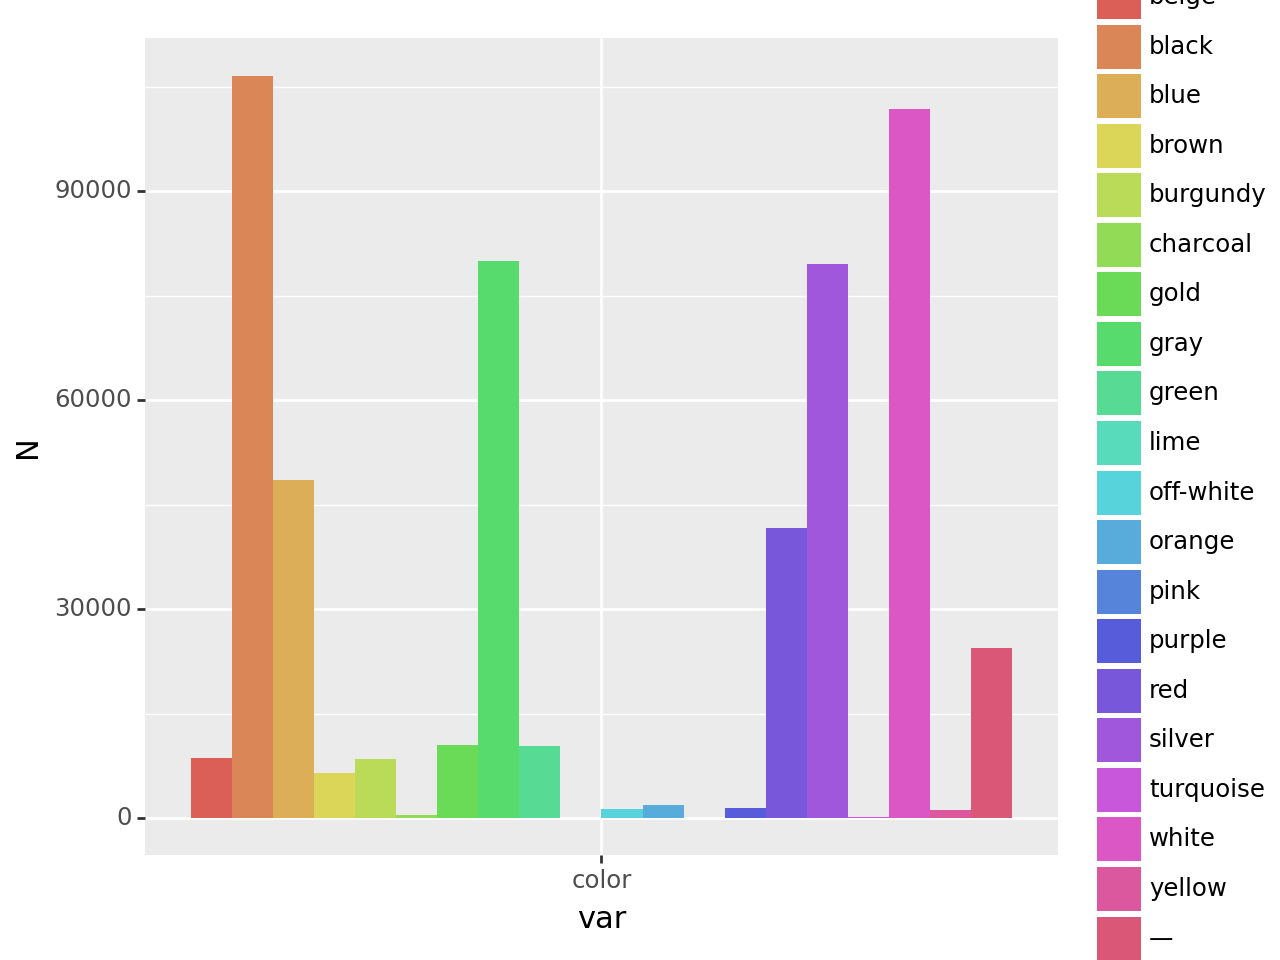

<Figure Size: (640 x 480)>

In [19]:
generate_freq_plot(generate_freq_table(df, ['color']))

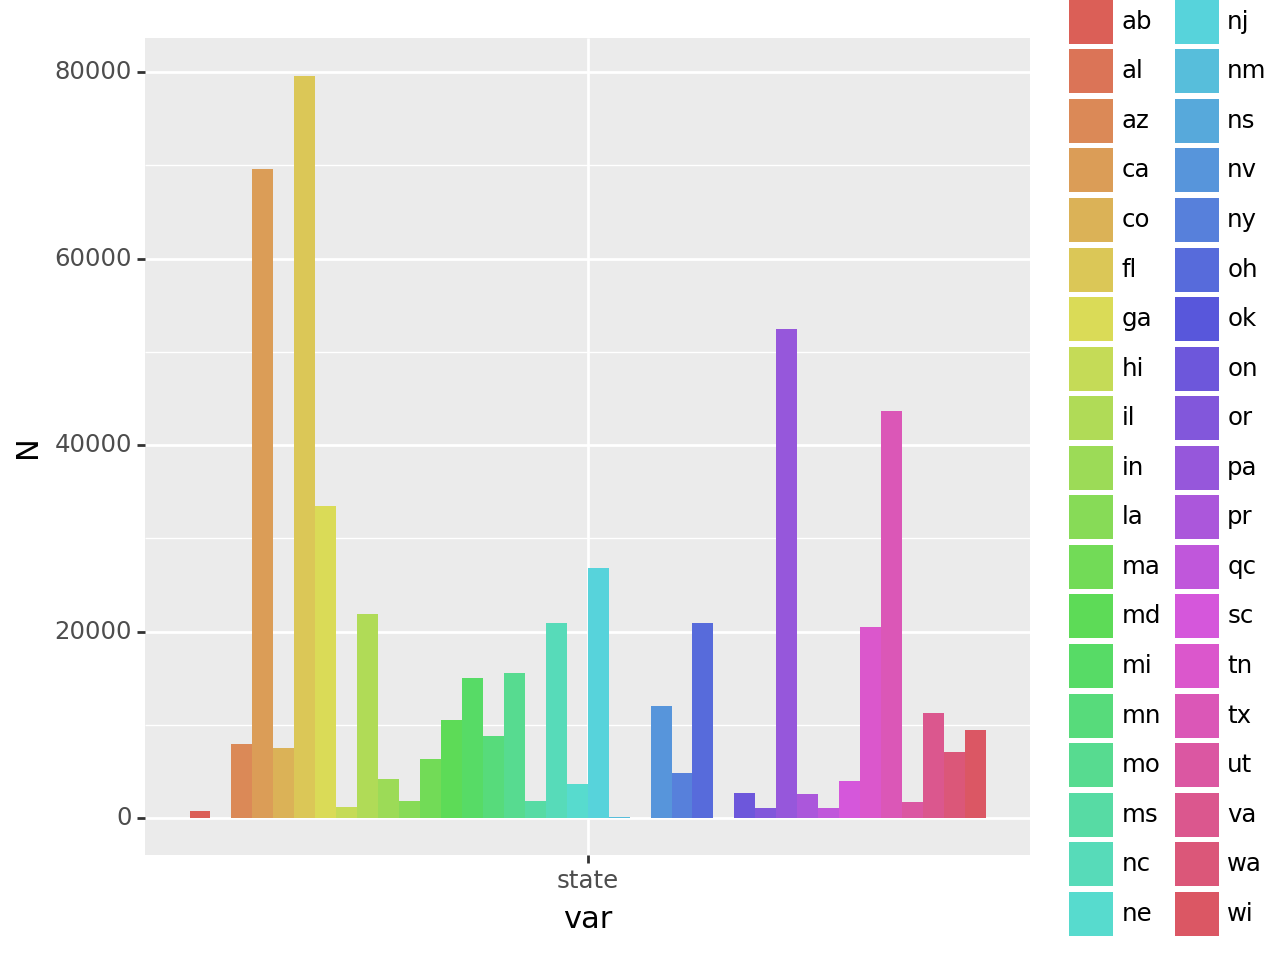

<Figure Size: (640 x 480)>

In [20]:
generate_freq_plot(generate_freq_table(df, ['state']))

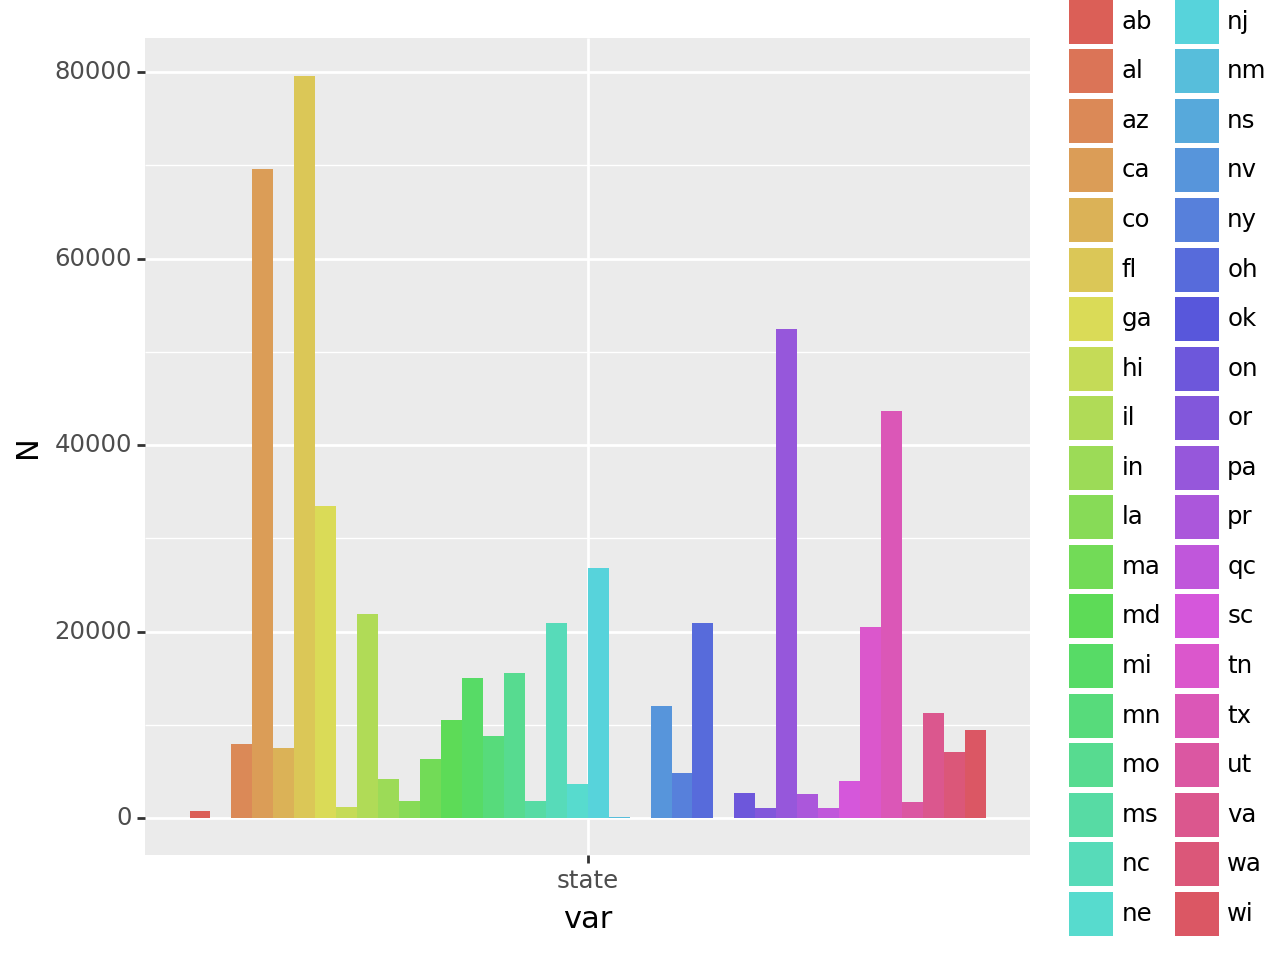

<Figure Size: (640 x 480)>

In [21]:
generate_freq_plot(generate_freq_table(df, ['state']))

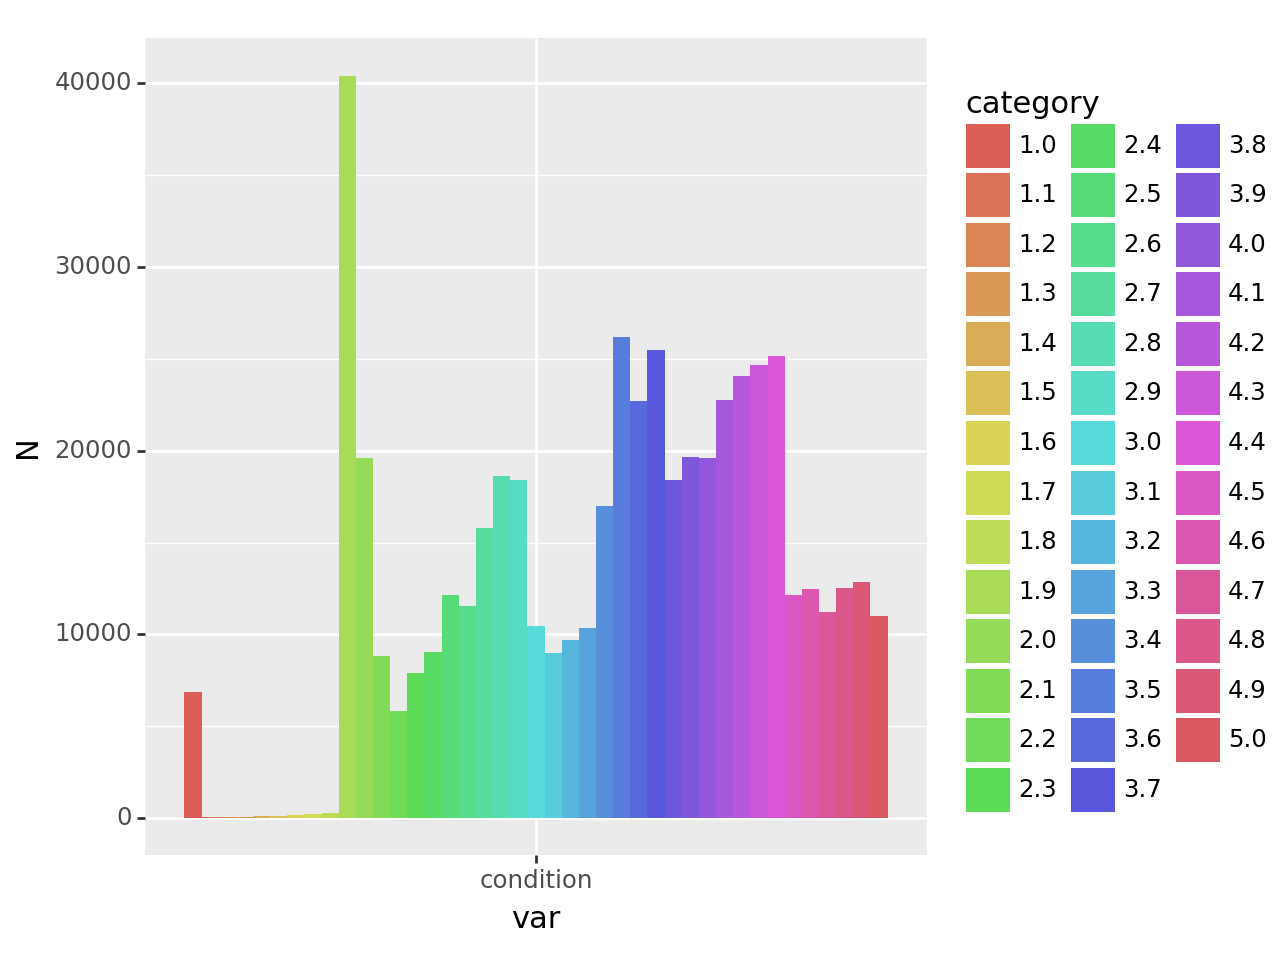

<Figure Size: (640 x 480)>

In [22]:
df_con = df.assign(cat = pd.cut(df['condition'], 10))
generate_freq_plot(generate_freq_table(df_con, ['condition']))

In [23]:
# # Get all column names except for 'sellingprice'
# feature_columns = df.columns[df.columns != ['sellingprice', 'vin']]

# # Loop through each feature column and create a scatter plot
# for feature in feature_columns:
#     # Check the number of unique values in the feature column
#     num_unique_values = df[feature].nunique()

#     if num_unique_values <= 50:
#         # If there are 50 or fewer unique values, create the scatter plot
#         sns.scatterplot(data=df, x=feature, y='sellingprice')
#         plt.title(f'Scatter Plot for {feature} vs Selling Price')
#         plt.show()
#     else:
#         # If there are more than 50 unique values, create the scatter plot with no x-axis ticks
#         sns.scatterplot(data=df, x=feature, y='sellingprice')
#         plt.title(f'Scatter Plot for {feature} vs Selling Price')
#         plt.xticks([])  # Remove x-axis ticks
#         plt.show()

ValueError: ('Shapes must match', (16,), (2,))